In [131]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

# **0. DATASETS**

*$\underline{\text{Linearly separable Dataset:}}$*

In [132]:
def linear_artificial_data(p, N):
    '''
    This function creates a linear separable dataset of two classes by generating 
    N i.i.d. vectors of 'p' number of features from a Multivariate Gaussian, with zero mean
    and identity covariance matrix. It returns the Nxp dataset and a vector of labels for
    the two classes 0 and 1.
    '''
    
    mean = np.zeros(p)
    covariance = np.identity(p) 
    
    #Generating the Nxp dataset
    X = np.random.multivariate_normal(mean, covariance, size=N)

    #Defining the classifier (ground truth), size = 1xp,
    #that defines the hyperplane for labeling the N samples (datapoints).
    classifier = np.random.multivariate_normal(mean, covariance)
    
    #Generating the labels
    y = ((np.sign(np.dot(X,classifier.T))+1)/2).astype(int)

    return X, y

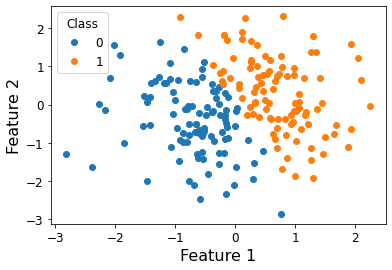

In [133]:
A,b = linear_artificial_data(2, 200)

#Pandas :)
df = pd.DataFrame(A, columns=["p1", "p2"])
df["Class"] = b

#Create the figure
fig, ax = plt.subplots() 
#Grouping by classes
groups = df.groupby("Class") 

for name, group in groups:
    plt.plot(group['p1'], group['p2'], marker = 'o', linestyle='', label = name)

ax.set_xlabel('Feature 1', fontsize=16)
ax.set_ylabel('Feature 2', fontsize=16)
ax.legend(title="Class", loc='best', title_fontsize='large', fontsize='large')
ax.tick_params(axis='both', labelsize=12)

*$\underline{\text{MNIST Dataset:}}$*


In [134]:
# load MNIST data from https://www.openml.org/d/554    
from sklearn.datasets import fetch_openml 
X_mnist, y_mnist = fetch_openml('mnist_784',version=1,return_X_y=True, as_frame=False)

# **1. FUNCTIONS**

In [185]:
def sigmoid(X, params):
    '''Logistic function: classification probability for the logistic regression'''
    z = np.dot(X, params)
    return 1/ (1 + np.exp(-z))

def softmax(X, params):
    '''Classification probability for the SoftMax algorithm'''
    #X = np.float64(X)
    #params = np.float64(params)
    z = np.dot(X,params)
    z = z - np.max(z)
    #probability
    Pi = np.exp(z) / np.sum(np.exp(z), axis =1).reshape((-1,1))
    return Pi

def one_hot_encoding(y, M):

    #Create a matrix of zeros with shape (N, M). where N=len(y) is the number of data points
    #and M the number of classes. 
    one_hot = np.zeros((len(y), M))
    
    #Selecting the index where we want to replace a 0 by 1:
    #np.arange(len(y)) creates a vector with the indices from 0 to N-1 of the matrix,
    #and a component of 'y' indicates the position of the column in which the number 
    #1 is going to be placed. When input both vectors as indices in the matrix,
    #we select at once all the coordinates in which we want to place the 1.  
    one_hot[np.arange(len(y)), y] = 1
    return one_hot


def L2_grad(X, y, params, L2_penalty, func):
    '''Gradient of the cost for the logistic or SoftMax regression (depending on 'func' input)
    with L2 penalization.
    '''
    A = func(X, params)
    grad = (np.dot(X.T,(A - y)) + L2_penalty*params)/X.shape[0] 
    return grad

def mini_batches(X, y, size_mini_batches, M):    
    '''
    This function creates non intersecting subsets of the dataset = (X,y) (mini-batches) 
    with size 'size_mini_batches', where N is the number of samples, p the number of features
    and m the number of classes. So, the dimension of X is Nxp, y is 1xN (For logistic regression) 
    or Nxm (for SoftMax regression). 
    '''
    #Randomly permutation of the number of samples 
    permutation = np.random.permutation(X.shape[0])

    #Shuffling the data:
    X_new = X[permutation] 
    y_new = y[permutation]

    #Splitting the data into non intersecting mini-batches:
    #the condition for the splitting is from index to index+chunk_size, i.e., X_new[index: index+chunk_size, :].
    #The function 'min' is used to include the case N%size_mini_batches != 0, such that the last mini-batch
    #will have a smaller value than 'size_mini_batches' if so.

    mini_X = [ X_new[ i*size_mini_batches: min(i*size_mini_batches + size_mini_batches , X.shape[0]) ] for i in range(M) ]
    mini_y = [ y_new[ i*size_mini_batches: min(i*size_mini_batches + size_mini_batches , X.shape[0]) ] for i in range(M) ]

    return mini_X, mini_y

def classification_accuracy(X,Y, params, func):
    ''' 
    This function computes the classification accuracy of the learned labels or also 
    the predicted labels y_class for the logistic or SoftMax regression.
    '''
    if func == softmax:
        y_c = np.argmax(softmax(X, params), axis=1)
        Y_class = one_hot_encoding(y_c, params.shape[1])
        accuracy = np.mean(np.all(Y == Y_class, axis=1))

    elif func == sigmoid:
        Y_class = (sigmoid(X, params) > 0.5)*1
        accuracy = np.mean(Y == Y_class)
    
    return accuracy

def stochastic_gradient_descent(X, y, param_init, size_mini_batches, grad, func, epochs, learning_rate, L2_penalty):
    '''
    This function calculates the weights (params) of the classification task by means of
    the Stochastic Gradient Descent optimization algorithm.
    '''

    #Initializing the vector of parameters
    params = np.array(param_init)
    #Number of indexes for creating the mini-batches
    M = math.ceil(X.shape[0] /size_mini_batches)
    #To store the accuracy per epoch
    accuracy_list = []

    for i in range(epochs):
        #Computing the mini-batches
        mini_X, mini_y = mini_batches(X, y, size_mini_batches, M)
        #loop over the mini-batches
        for j in range(len(mini_X)):
            v = learning_rate* grad(mini_X[j], mini_y[j], params, L2_penalty, func)
            params = params - v  
           
        #Monitoring of the training error at each step in the epochs
        accuracy = classification_accuracy(X, y, params, func)
        accuracy_list.append(accuracy)
   
    return params, accuracy_list

def nesterov_accelerated_gradient(X, y, param_init, size_mini_batches, grad, func, epochs, learning_rate, gamma, L2_penalty): 
    '''
    This function calculates the weights (params) of the classification task by means of
    the Nesterov's Accelerated Gradient optimization algorithm.
    '''
    #Initializing the vector of parameters
    params = np.array(param_init)
    #Number of indexes for creating the mini-batches
    M = math.ceil(X.shape[0] /size_mini_batches)
    #To store the accuracy per epoch
    accuracy_list = []
    v = 0

    for i in range(epochs):
        #Computing the mini-batches
        mini_X, mini_y = mini_batches(X, y, size_mini_batches, M)
        #loop over the mini-batches
        for j in range(len(mini_X)):
            params_nesterov = params - gamma* v
            v = gamma * v + learning_rate* grad(mini_X[j], mini_y[j], params_nesterov, L2_penalty, func)
            params = params - v  

        #Monitoring of the training error at each step in the epoch
        accuracy = classification_accuracy(X, y, params, func)
        accuracy_list.append(accuracy)

    return params, accuracy_list

*$\underline{\text{Main Function:}}$*

In [142]:
def main(X, y, train_size, param_init, func, epochs, learning_rate, gamma, size_mini_batches, lmbdas):
    #Initialize lists to append coefficients and errors for SGD and NAG
    coefs_SGD = []
    coefs_NAG = []

    train_accuracy_SGD = []
    test_accuracy_SGD = []

    train_accuracy_NAG = []
    test_accuracy_NAG = []

    accuracy_epoch_SGD = []
    accuracy_epoch_NAG = []

    XTest = []

    i = 0
    for lmbda in lmbdas:
        # Shuffling the data
        permutation = np.random.permutation(X.shape[0])
        X = X[permutation]
        y = y[permutation]
        

        # Defining train and test data sets
        X_train = X[:train_size]
        y_train = y[:train_size]
        X_test = X[train_size:N+1]
        y_test = y[train_size:N+1]

        XTest.append(X_test)


        #Training
        params_SGD, accuracy_eSGD = stochastic_gradient_descent(X_train, y_train, param_init, size_mini_batches, 
                                                                L2_grad, func, epochs, learning_rate, lmbda)
        params_NAG, accuracy_eNAG = nesterov_accelerated_gradient(X_train, y_train, param_init, size_mini_batches,
                                                                  L2_grad, func, epochs, learning_rate, gamma, lmbda)

        coefs_SGD.append(params_SGD)
        coefs_NAG.append(params_NAG)

        accuracy_epoch_SGD.append(accuracy_eSGD)
        accuracy_epoch_NAG.append(accuracy_eNAG)

        train_accuracy_SGD.append(classification_accuracy(X_train,y_train, params_SGD, func))
        test_accuracy_SGD.append(classification_accuracy(X_test,y_test, params_SGD, func))

        train_accuracy_NAG.append(classification_accuracy(X_train,y_train, params_NAG, func))
        test_accuracy_NAG.append(classification_accuracy(X_test,y_test, params_NAG, func))
        
        print('\n')
        print('-*--*-- Penalization strength:', lmbda)
        print('Test accuracy SGD DIY:', test_accuracy_SGD[i])
        print('Train accuracy SGD DIY:', train_accuracy_SGD[i])
        print('Test accuracy NAG DIY:', test_accuracy_NAG[i])
        print('Train accuracy NAG DIY:', train_accuracy_NAG[i])
        i += 1

    return XTest, coefs_SGD, coefs_NAG, accuracy_epoch_SGD, accuracy_epoch_NAG, train_accuracy_SGD, test_accuracy_SGD, train_accuracy_NAG, test_accuracy_NAG

# **2. L2 PENALIZED LOGISTIC REGRESSION**

### **Logistic regression for the linear data set**

In [256]:
## ======= Logistic regression for the linear data set ======= 
N = 250 #Number of samples/ data points
p = 2 #Number of features

X, y = linear_artificial_data(p, N)

X = X / np.max(X)
train_size = math.floor(0.7*N) 
test_size = N - train_size  

param_init = np.zeros(p) #np.random.multivariate_normal(mean= np.zeros(p), cov= np.identity(p))
epochs = 50
learning_rate = 10**-3
gamma = 0.9
size_mini_batches = math.floor(0.05*test_size)
lmbdas = np.logspace(-5, -1, 10) #From 10^-5 to 10^-1, number of values= 10.

XTest, coefs_SGD, coefs_NAG, accuracy_epoch_SGD, accuracy_epoch_NAG, train_accuracy_SGD, test_accuracy_SGD, train_accuracy_NAG, test_accuracy_NAG = main(X, y, train_size, param_init, sigmoid ,epochs, learning_rate, gamma, size_mini_batches, lmbdas)



-*--*-- Penalization strength: 1e-05
Test accuracy SGD DIY: 0.9333333333333333
Train accuracy SGD DIY: 0.9714285714285714
Test accuracy NAG DIY: 0.9466666666666667
Train accuracy NAG DIY: 0.9714285714285714


-*--*-- Penalization strength: 2.782559402207126e-05
Test accuracy SGD DIY: 0.9333333333333333
Train accuracy SGD DIY: 0.9771428571428571
Test accuracy NAG DIY: 0.9333333333333333
Train accuracy NAG DIY: 0.9771428571428571


-*--*-- Penalization strength: 7.742636826811278e-05
Test accuracy SGD DIY: 0.96
Train accuracy SGD DIY: 0.9657142857142857
Test accuracy NAG DIY: 0.9733333333333334
Train accuracy NAG DIY: 0.9771428571428571


-*--*-- Penalization strength: 0.00021544346900318823
Test accuracy SGD DIY: 0.96
Train accuracy SGD DIY: 0.9714285714285714
Test accuracy NAG DIY: 0.9733333333333334
Train accuracy NAG DIY: 0.9771428571428571


-*--*-- Penalization strength: 0.0005994842503189409
Test accuracy SGD DIY: 0.9466666666666667
Train accuracy SGD DIY: 0.9542857142857143
Tes

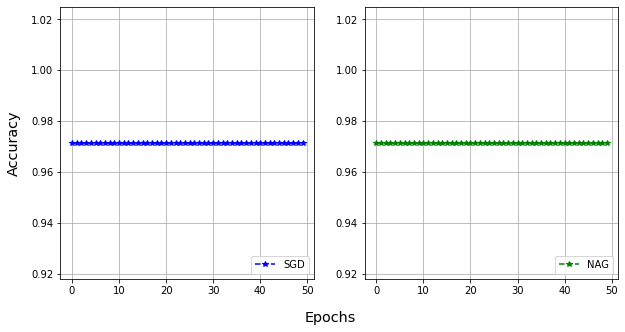

In [257]:
#accuracy vs epoch for the first penalization strength
fig, ax = plt.subplots(1,2, figsize=(10,5))
epoch_ar = np.arange(epochs) 
lmda_fixed = 0

ax[0].plot(epoch_ar, accuracy_epoch_SGD[0], '*--b', label = 'SGD')
ax[1].plot(epoch_ar, accuracy_epoch_NAG[0], '*--g', label = 'NAG')

fig.text(0.5, 0.005, 'Epochs', ha='center', fontsize = 'x-large')
ax[0].set_ylabel('Accuracy', fontsize = 'x-large', labelpad = 10)
ax[0].grid()
ax[1].grid()
ax[0].legend(loc = 'lower right')
ax[1].legend(loc = 'lower right')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  if __name__ == '__main__':


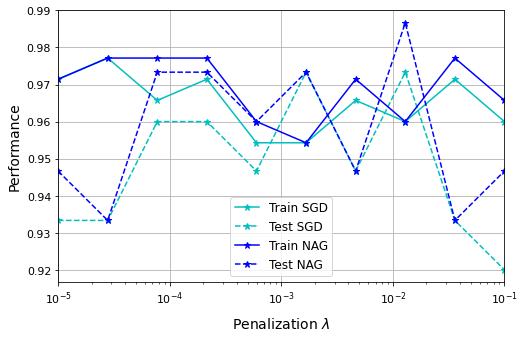

In [258]:
#Visualizing the performances
fig, ax = plt.subplots(figsize=(8,5))
ax.semilogx(lmbdas, train_accuracy_SGD,  '*-c', label='Train SGD', linewidth=1.5, markersize = 7)
ax.semilogx(lmbdas, test_accuracy_SGD, '*--c', label='Test SGD', linewidth=1.5, markersize = 7)
ax.semilogx(lmbdas, train_accuracy_NAG, '*-b', label='Train NAG', linewidth=1.5, markersize = 7)
ax.semilogx(lmbdas, test_accuracy_NAG, '*--b', label='Test NAG', linewidth=1.5, markersize = 7)

ax.legend(loc='best',fontsize=12)
ax.set_xlim([-0.1, 1.1])
ax.set_xlim([min(lmbdas), max(lmbdas)])
ax.set_xlabel(r'Penalization $\lambda$', fontsize=14, labelpad = 10)
ax.set_ylabel('Performance', fontsize=14, labelpad = 5.5)
ax.tick_params(axis='both', labelsize=11)
ax.grid()
fig.show()

when we do cross-validation we select the value of the parameter that has the lowest test or out-of-sample error (best performance). In the above image I used the classification accuracy as a performance measure. The value of the penalization strength that gave the best performance for the test data is $\lambda = 1.29\text{x}10^{-2}$ for both SGD and NAG.

In [259]:
#Extracting the value of lambda that works better and plot
y_class_SGD = (sigmoid(X, coefs_SGD[7]) > 0.5)*1
y_class_NAG = (sigmoid(X, coefs_NAG[7]) > 0.5)*1

Text(0.5, 1.0, 'Logistic regression NAG')

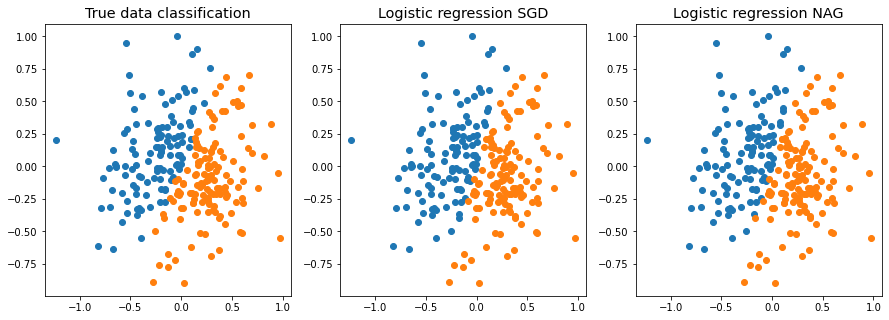

In [260]:
df = pd.DataFrame(X, columns=["p1", "p2"])
df["Class"] = y
df2 = pd.DataFrame(X, columns=["p1", "p2"])
df2["Class"] = y_class_SGD
df3 = pd.DataFrame(X, columns=["p1", "p2"])
df3["Class"] = y_class_NAG

#Create the figure
fig, ax = plt.subplots(1,3, figsize=(15,5)) 
#Grouping by classes
groups = df.groupby("Class") 
groups2 = df2.groupby("Class") 
groups3 = df3.groupby("Class") 

for name, group in groups:
    ax[0].plot(group['p1'], group['p2'], marker = 'o', linestyle='', label = name)

ax[0].set_title('True data classification', size = 'x-large')

for name, group in groups2:
    ax[1].plot(group['p1'], group['p2'], marker = 'o', linestyle='', label = name)

ax[1].set_title('Logistic regression SGD', size = 'x-large')

for name, group in groups3:
    ax[2].plot(group['p1'], group['p2'], marker = 'o', linestyle='', label = name)

ax[2].set_title('Logistic regression NAG', size = 'x-large')

### **Logistic regression for the MNIST data set**

In [261]:
#70000 Datapoints 784 features (pixels)

#Choosing the numbers 2 and 4 from the MNIST dataset
filter_idx = np.where((y_mnist == '2' ) | (y_mnist == '4'))
X = X_mnist[filter_idx] / X_mnist.max()
y = y_mnist[filter_idx].astype(float)

#Replacing the labels with 1 and 0     
y = np.where(y == 2, 1.0, y)
y = np.where(y == 4, 0.0, y)

In [262]:
## ======= Logistic regression for the MNIST data set ======= 
N = X.shape[0]
p = X.shape[1]
train_size = math.floor(0.7*N) 
test_size = N - train_size 


param_init = np.random.multivariate_normal(mean= np.zeros(p), cov= np.identity(p)) #np.zeros(p) 
epochs = 100
learning_rate = 10**-2
gamma = 0.9
size_mini_batches = math.floor(0.1*test_size)
lmbdas = np.logspace(-4, -1, 10) #From 10^-4 to 10^-1, number of values= 10.

XTest, coefs_SGD, coefs_NAG, accuracy_epoch_SGD, accuracy_epoch_NAG, train_accuracy_SGD, test_accuracy_SGD, train_accuracy_NAG, test_accuracy_NAG = main(X, y, train_size, param_init, sigmoid ,epochs, learning_rate, gamma, size_mini_batches, lmbdas)



-*--*-- Penalization strength: 0.0001
Test accuracy SGD DIY: 0.9396863691194209
Train accuracy SGD DIY: 0.9453924914675768
Test accuracy NAG DIY: 0.9722557297949337
Train accuracy NAG DIY: 0.9779708346261248


-*--*-- Penalization strength: 0.00021544346900318845
Test accuracy SGD DIY: 0.9469240048250904
Train accuracy SGD DIY: 0.9431171786120591
Test accuracy NAG DIY: 0.9765983112183353
Train accuracy NAG DIY: 0.9780742579377392


-*--*-- Penalization strength: 0.00046415888336127773
Test accuracy SGD DIY: 0.9425814234016888
Train accuracy SGD DIY: 0.9436342951701313
Test accuracy NAG DIY: 0.9794933655006032
Train accuracy NAG DIY: 0.9769366015099803


-*--*-- Penalization strength: 0.001
Test accuracy SGD DIY: 0.9490952955367913
Train accuracy SGD DIY: 0.9424966387423726
Test accuracy NAG DIY: 0.9744270205066345
Train accuracy NAG DIY: 0.9785913744958114


-*--*-- Penalization strength: 0.002154434690031882
Test accuracy SGD DIY: 0.9401688781664657
Train accuracy SGD DIY: 0.9449787

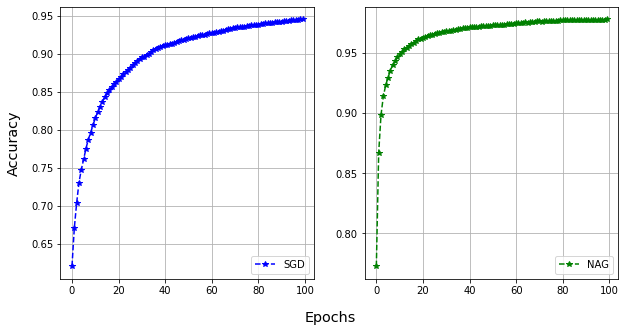

In [263]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
epoch_ar = np.arange(epochs) 
lmda_fixed = 0

ax[0].plot(epoch_ar, accuracy_epoch_SGD[0], '*--b', label = 'SGD')
ax[1].plot(epoch_ar, accuracy_epoch_NAG[0], '*--g', label = 'NAG')

fig.text(0.5, 0.005, 'Epochs', ha='center', fontsize = 'x-large')
ax[0].set_ylabel('Accuracy', fontsize = 'x-large', labelpad = 10)
ax[0].grid()
ax[1].grid()
ax[0].legend(loc = 'lower right')
ax[1].legend(loc = 'lower right')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  if __name__ == '__main__':


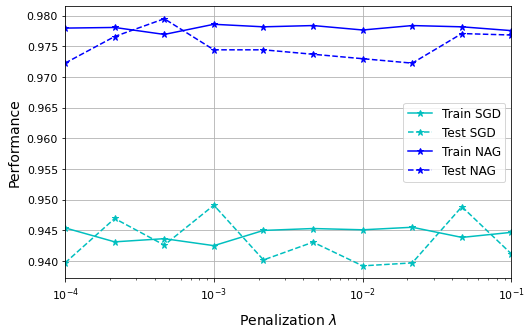

In [265]:
#Visualizing the performances
fig, ax = plt.subplots(figsize=(8,5))
ax.semilogx(lmbdas, train_accuracy_SGD,  '*-c', label='Train SGD', linewidth=1.5, markersize = 7)
ax.semilogx(lmbdas, test_accuracy_SGD, '*--c', label='Test SGD', linewidth=1.5, markersize = 7)
ax.semilogx(lmbdas, train_accuracy_NAG, '*-b', label='Train NAG', linewidth=1.5, markersize = 7)
ax.semilogx(lmbdas, test_accuracy_NAG, '*--b', label='Test NAG', linewidth=1.5, markersize = 7)

ax.legend(loc='best',fontsize=12)
ax.set_xlim([-0.1, 1.1])
ax.set_xlim([min(lmbdas), max(lmbdas)])
ax.set_xlabel(r'Penalization $\lambda$', fontsize=14, labelpad = 10)
ax.set_ylabel('Performance', fontsize=14, labelpad = 5.5)
ax.tick_params(axis='both', labelsize=11)
ax.grid()
fig.show()

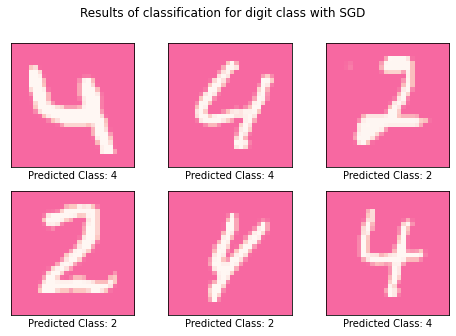

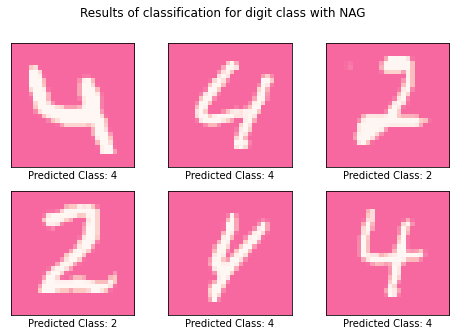

In [266]:
coefs = [coefs_SGD[3], coefs_NAG[2]]
title = ['SGD', 'NAG']
j = 0
X_test = XTest[4]

for coef in coefs:

    plt.figure(figsize=(8,5))

    for i in range(6):
        ax = plt.subplot(2, 3, i + 1)
        #reshaping the 'data point' of 784 features to a matrix of size 28 by 28
        figure = X_test[i].reshape(28,28)
        scale = np.abs(figure).max()
        ax.imshow(figure, interpolation='nearest', cmap=plt.cm.RdPu_r, vmin=-scale, vmax=scale)
        #Predicting with the value of lamdba that works better.
        y_class = (sigmoid(X_test[i], coef) > 0.5)*1 
        ax.set_xticks(())
        ax.set_yticks(())

        if y_class == 1: y_class = 2
        else: y_class = 4
        ax.set_xlabel('Predicted Class: %i' % y_class)

    plt.suptitle('Results of classification for digit class with ' + title[j])
    j += 1

The last two images show that, in this case, the NAG has a higher performance for the training and test data than SGD. This fact can also be seen in the classification results when choosing the best penalization strength for both algorithms, where SGD classified a number 4 as 2 but NAG correctly classified it. 

# **3. L2 PENALIZED SOFTMAX REGRESSION**


For $M$ classes we want to estimate the probabily $P(y=j|\bf{x^{(i)}}, \bf{\theta})$ of each data point $i$ to belong to a class $j$, for each value of $j=0,…,M-1$:

$$P^{(i)}_j = P(y=0|\bf{x^{(i)}}, \bf{\theta}) = \frac{e^{ \bf{x^{(i)}}\bf{\theta}_j}}{\sum_{j'=0}^{M-1} \; e^{\bf{x^{(i)}}\bf{\theta}_{j'}}} $$

So that the matrix of probabilities will be:

\begin{equation}
\bf{P} =
\begin{bmatrix}
P^{(0)}_0 & \dots & P^{(0)}_{M-1}   \\
P^{(1)}_0 & \dots & P^{(1)}_{M-1} \\
\vdots    &\ddots    &\vdots\\
P^{(N-1)}_0 & \dots & P^{(N-1)}_{M-1}
\end{bmatrix} 
\end{equation}

in this case $\bf{\theta}$ is a $p$ by $M$ matrix with $p$ the number of features, and it is defined as $\theta = [\bf{\theta}_0, \bf{\theta}_1, \dots, \bf{\theta}_{M-1}]$, with $\bf{\theta}_j \in \mathbb{R}^p$. $\bf{X}$ is a matrix of size $N$ by $p$, so $\bf{x^{(i)}}$ is the row ${i}$ or datapoint ${i}$.

The label of each data point is selected as the maximum probability among classes. So then the matrix of predicted classes $Y^*$ (the predicted $Y$ in the one-hot representation) is composed by 0's and 1's, where the number 1 is in the column index of the maximum probability for each data point/ row index.

###**SoftMax regression for the linear data set (2 classes)**

In [267]:
## ======= Softmax regression for the linear data set ======= 
p = 2 #number of features
N = 200 #number of data points
X, y = linear_artificial_data(p, N)
m = len(set(y))
Y = one_hot_encoding(y, m)
X = X / np.max(X)

train_size = math.floor(0.7*N) 
test_size = N - train_size  

param_init = np.random.rand(p,m) ##np.zeros((p, M)) 
epochs = 50
learning_rate = 10**-3
gamma = 0.9
size_mini_batches = math.floor(0.05*test_size)
lmbdas = np.logspace(-5, -1, 10) #From 10^-5 to 10^-1, number of values= 10.

XTest, coefs_SGD, coefs_NAG, accuracy_epoch_SGD, accuracy_epoch_NAG, train_accuracy_SGD, test_accuracy_SGD, train_accuracy_NAG, test_accuracy_NAG = main(X, Y, train_size, param_init, softmax ,epochs, learning_rate, gamma, size_mini_batches, lmbdas)



-*--*-- Penalization strength: 1e-05
Test accuracy SGD DIY: 0.7666666666666667
Train accuracy SGD DIY: 0.8642857142857143
Test accuracy NAG DIY: 0.95
Train accuracy NAG DIY: 0.9857142857142858


-*--*-- Penalization strength: 2.782559402207126e-05
Test accuracy SGD DIY: 0.8833333333333333
Train accuracy SGD DIY: 0.9
Test accuracy NAG DIY: 0.9833333333333333
Train accuracy NAG DIY: 0.9857142857142858


-*--*-- Penalization strength: 7.742636826811278e-05
Test accuracy SGD DIY: 0.9166666666666666
Train accuracy SGD DIY: 0.8928571428571429
Test accuracy NAG DIY: 1.0
Train accuracy NAG DIY: 0.9928571428571429


-*--*-- Penalization strength: 0.00021544346900318823
Test accuracy SGD DIY: 0.9
Train accuracy SGD DIY: 0.85
Test accuracy NAG DIY: 0.9833333333333333
Train accuracy NAG DIY: 0.9857142857142858


-*--*-- Penalization strength: 0.0005994842503189409
Test accuracy SGD DIY: 0.8333333333333334
Train accuracy SGD DIY: 0.8357142857142857
Test accuracy NAG DIY: 0.95
Train accuracy NAG D

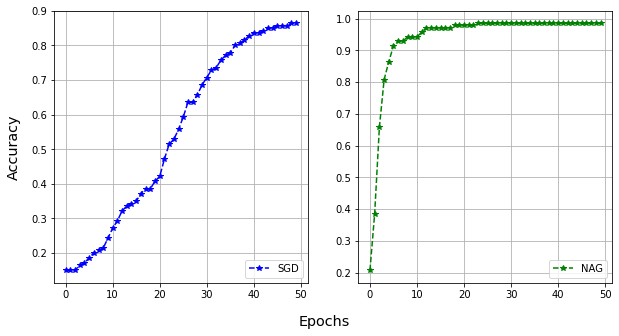

In [268]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
epoch_ar = np.arange(epochs) 
lmda_fixed = 0

ax[0].plot(epoch_ar, accuracy_epoch_SGD[0], '*--b', label = 'SGD')
ax[1].plot(epoch_ar, accuracy_epoch_NAG[0], '*--g', label = 'NAG')

fig.text(0.5, 0.005, 'Epochs', ha='center', fontsize = 'x-large')
ax[0].set_ylabel('Accuracy', fontsize = 'x-large', labelpad = 10)
ax[0].grid()
ax[1].grid()
ax[0].legend(loc = 'lower right')
ax[1].legend(loc = 'lower right')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  if __name__ == '__main__':


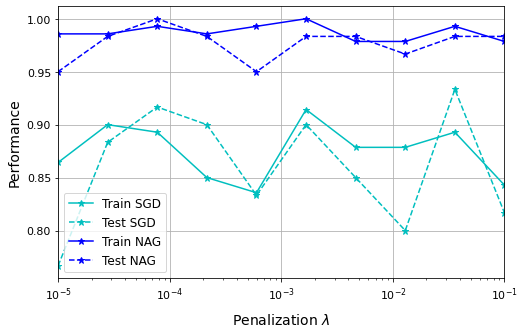

In [269]:
#Visualizing the performances
fig, ax = plt.subplots(figsize=(8,5))
ax.semilogx(lmbdas, train_accuracy_SGD,  '*-c', label='Train SGD', linewidth=1.5, markersize = 7)
ax.semilogx(lmbdas, test_accuracy_SGD, '*--c', label='Test SGD', linewidth=1.5, markersize = 7)
ax.semilogx(lmbdas, train_accuracy_NAG, '*-b', label='Train NAG', linewidth=1.5, markersize = 7)
ax.semilogx(lmbdas, test_accuracy_NAG, '*--b', label='Test NAG', linewidth=1.5, markersize = 7)

ax.legend(loc='best',fontsize=12)
ax.set_xlim([-0.1, 1.1])
ax.set_xlim([min(lmbdas), max(lmbdas)])
ax.set_xlabel(r'Penalization $\lambda$', fontsize=14, labelpad = 10)
ax.set_ylabel('Performance', fontsize=14, labelpad = 5.5)
ax.tick_params(axis='both', labelsize=11)
ax.grid()
fig.show()

### **SoftMax regression for the MNIST data set**

In [271]:
#From the MNIST dataset 70000 Datapoints 784 features (pixels)
X = X_mnist / X_mnist.max()
y = y_mnist.astype(int)
m = len(set(y))
Y = one_hot_encoding(y, m)

In [275]:
## ======= Softmax regression for the MNIST data set ======= 
N = X.shape[0]
p = X.shape[1]
train_size = math.floor(0.7*N)
test_size = N - train_size

param_init = np.random.rand(p,m) #np.zeros((p, M)) 
epochs = 40
learning_rate = 10**-1
gamma = 0.9
size_mini_batches = math.floor(0.1*test_size)
lmbdas = np.logspace(-5, -1, 6) #From 10^-5 to 10^-1, number of values = 6.

XTest, coefs_SGD, coefs_NAG, accuracy_epoch_SGD, accuracy_epoch_NAG, train_accuracy_SGD, test_accuracy_SGD, train_accuracy_NAG, test_accuracy_NAG = main(X, Y, train_size, param_init, softmax ,epochs, learning_rate, gamma, size_mini_batches, lmbdas)




-*--*-- Penalization strength: 1e-05
Test accuracy SGD DIY: 0.8779047619047619
Train accuracy SGD DIY: 0.8834285714285715
Test accuracy NAG DIY: 0.9128095238095238
Train accuracy NAG DIY: 0.9223061224489796


-*--*-- Penalization strength: 6.309573444801929e-05
Test accuracy SGD DIY: 0.8806190476190476
Train accuracy SGD DIY: 0.8833469387755102
Test accuracy NAG DIY: 0.9143809523809524
Train accuracy NAG DIY: 0.9224489795918367


-*--*-- Penalization strength: 0.00039810717055349735
Test accuracy SGD DIY: 0.8801904761904762
Train accuracy SGD DIY: 0.8826938775510204
Test accuracy NAG DIY: 0.9134285714285715
Train accuracy NAG DIY: 0.9219387755102041


-*--*-- Penalization strength: 0.002511886431509582
Test accuracy SGD DIY: 0.8801428571428571
Train accuracy SGD DIY: 0.8828571428571429
Test accuracy NAG DIY: 0.9141428571428571
Train accuracy NAG DIY: 0.9223265306122449


-*--*-- Penalization strength: 0.01584893192461114
Test accuracy SGD DIY: 0.8823809523809524
Train accuracy SGD DI

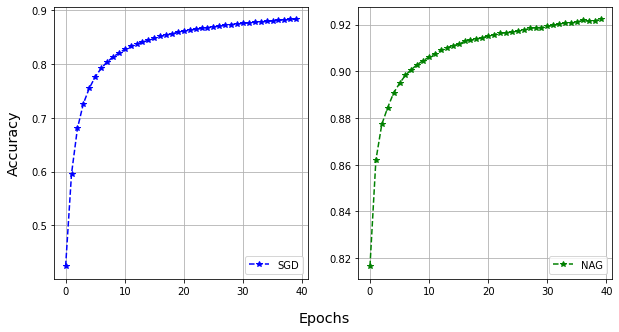

In [276]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
epoch_ar = np.arange(epochs) 
lmda_fixed = 0

ax[0].plot(epoch_ar, accuracy_epoch_SGD[0], '*--b', label = 'SGD')
ax[1].plot(epoch_ar, accuracy_epoch_NAG[0], '*--g', label = 'NAG')

fig.text(0.5, 0.005, 'Epochs', ha='center', fontsize = 'x-large')
ax[0].set_ylabel('Accuracy', fontsize = 'x-large', labelpad = 10)
ax[0].grid()
ax[1].grid()
ax[0].legend(loc = 'lower right')
ax[1].legend(loc = 'lower right')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  if __name__ == '__main__':


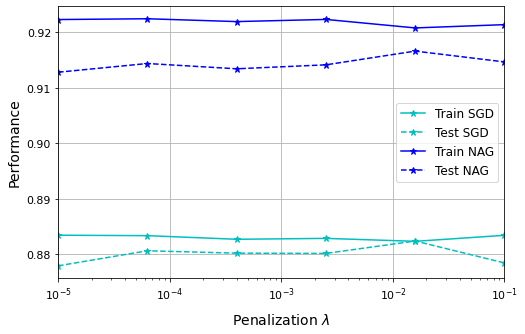

In [277]:
#Visualizing the performances
fig, ax = plt.subplots(figsize=(8,5))
ax.semilogx(lmbdas, train_accuracy_SGD,  '*-c', label='Train SGD', linewidth=1.5, markersize = 7)
ax.semilogx(lmbdas, test_accuracy_SGD, '*--c', label='Test SGD', linewidth=1.5, markersize = 7)
ax.semilogx(lmbdas, train_accuracy_NAG, '*-b', label='Train NAG', linewidth=1.5, markersize = 7)
ax.semilogx(lmbdas, test_accuracy_NAG, '*--b', label='Test NAG', linewidth=1.5, markersize = 7)

ax.legend(loc='best',fontsize=12)
ax.set_xlim([-0.1, 1.1])
ax.set_xlim([min(lmbdas), max(lmbdas)])
ax.set_xlabel(r'Penalization $\lambda$', fontsize=14, labelpad = 10)
ax.set_ylabel('Performance', fontsize=14, labelpad = 5.5)
ax.tick_params(axis='both', labelsize=11)
ax.grid()
fig.show()

The value of the penalization strength that gave the best performance for the test data is $\lambda = 1.58\text{x}10^{-2}$ for both SGD and NAG.

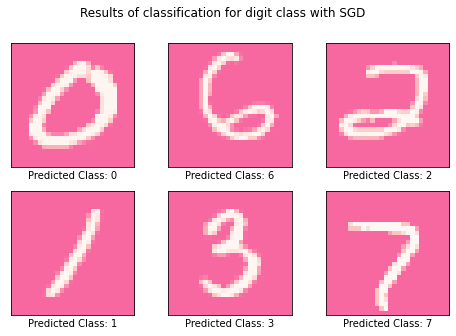

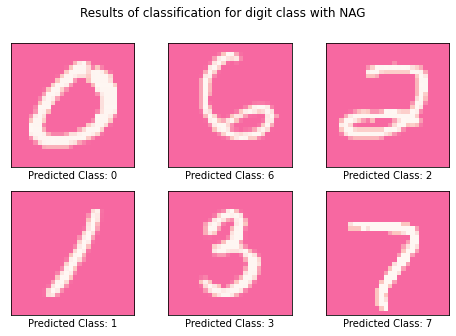

In [280]:
coefs = [coefs_SGD[4], coefs_NAG[4]]
title = ['SGD', 'NAG']
j = 0
X_test = XTest[4]

y_c_SGD = np.argmax(softmax(X_test, coefs[0]), axis=1)
y_c_NAG = np.argmax(softmax(X_test, coefs[1]), axis=1)

Class_SGD = one_hot_encoding(y_c_SGD, coefs[0].shape[1])
Class_NAG = one_hot_encoding(y_c_NAG, coefs[1].shape[1])


y_class = [Class_SGD,Class_NAG]

for coef in coefs:
    
    plt.figure(figsize=(8,5))

    for i in range(6):
        ax = plt.subplot(2, 3, i + 1)
        #reshaping the 'data point' of 784 features to a matrix of size 28 by 28
        figure = X_test[i].reshape(28,28) #extrayendo la imagen y reshaping
        scale = np.abs(figure).max()
        ax.imshow(figure, interpolation='nearest', cmap=plt.cm.RdPu_r, vmin=-scale, vmax=scale)
        #extracting the precited label of the image.
        if  j == 0: A = np.argmax(y_class[0][i]) 
        else:  A = A = np.argmax(y_class[1][i])
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_xlabel('Predicted Class: %i' % A)

    plt.suptitle('Results of classification for digit class with ' + title[j])

    j += 1